In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time

In [3]:
# Visualize the data
def visualize_data(data_loader, class_names):
    images, labels = next(data_loader)
    fig, axs = plt.subplots(3, 3, figsize=(12, 12))
    for i in range(9):
        row = i // 3
        col = i % 3
        ax = axs[row, col]
        # Rescale images back to [0, 255] for display
        img = (images[i] * 255).astype("uint8")
        ax.imshow(img)
        label_idx = np.argmax(labels[i])
        ax.set_title(class_names[label_idx])
        ax.axis('off')
    plt.show()

In [4]:
# Data augmentation functions
def horizontal_flip(image, label):
    image = tf.image.flip_left_right(image)
    return image, label

def vertical_flip(image, label):
    image = tf.image.flip_up_down(image)
    return image, label


In [5]:
# Load and preprocess the data
def load_and_preprocess_data(data_dir, image_size, batch_size):
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    
    train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'
    )

    validation_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation'
    )
    
    return train_generator, validation_generator

In [6]:
# Define and compile the model
def create_compile_model(image_size, num_classes):
    base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(32, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    for layer in base_model.layers:
        layer.trainable = False
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [7]:
# Train the model
def train_model(model, train_generator, validation_generator, epochs, batch_size):
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // batch_size
    )
    return history


In [8]:
# Plot training history
def plot_history(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.show()

Found 5505 images belonging to 11 classes.
Found 1372 images belonging to 11 classes.


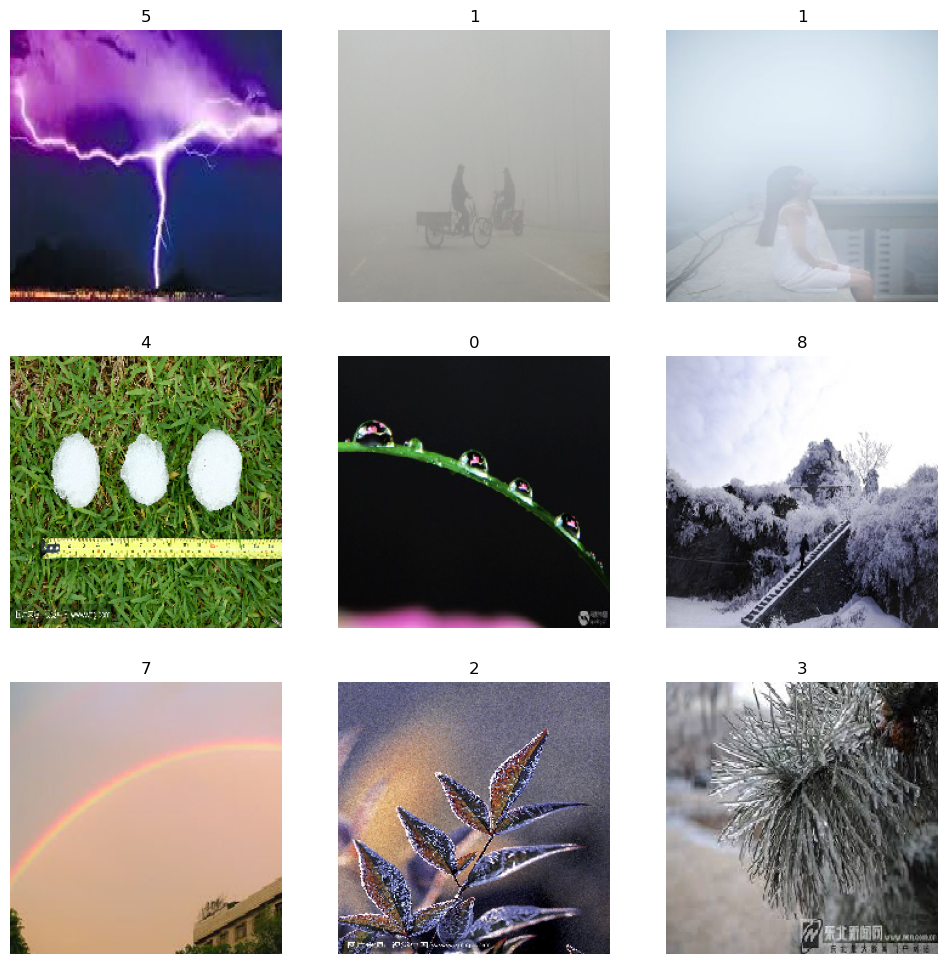

Epoch 1/29
172/172 [==============================] - 2684s 15s/step - loss: 1.5785 - accuracy: 0.4752 - val_loss: 0.6602 - val_accuracy: 0.7842
Epoch 2/29
172/172 [==============================] - 3079s 18s/step - loss: 0.7946 - accuracy: 0.7385 - val_loss: 0.5091 - val_accuracy: 0.8348
Epoch 3/29
172/172 [==============================] - 3019s 18s/step - loss: 0.5966 - accuracy: 0.8069 - val_loss: 0.5071 - val_accuracy: 0.8318
Epoch 4/29
172/172 [==============================] - 3027s 18s/step - loss: 0.4722 - accuracy: 0.8465 - val_loss: 0.4853 - val_accuracy: 0.8408
Epoch 5/29
172/172 [==============================] - 2979s 17s/step - loss: 0.4011 - accuracy: 0.8747 - val_loss: 0.4515 - val_accuracy: 0.8571
Epoch 6/29
172/172 [==============================] - 2889s 17s/step - loss: 0.3620 - accuracy: 0.8851 - val_loss: 0.4449 - val_accuracy: 0.8616
Epoch 7/29
172/172 [==============================] - 3156s 18s/step - loss: 0.3229 - accuracy: 0.8971 - val_loss: 0.5280 - val_ac

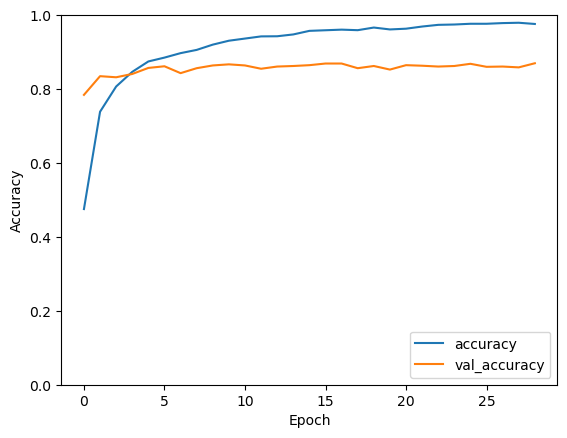

Total time:  1230.0  mins  0.6797482967376709  secs


In [9]:
start = time.time()

# Parameters
data_dir = 'C:/dataset'
batch_size = 32
epochs = 29
image_size = (224, 224)
num_classes = 11
class_names = [str(i) for i in range(num_classes)]  # Replace with actual class names

# Set seeds for reproducibility
np.random.seed(20)
random.seed(20)
tf.random.set_seed(20)

# Load and preprocess data
train_generator, validation_generator = load_and_preprocess_data(data_dir, image_size, batch_size)

# Visualize some samples
visualize_data(train_generator, class_names)

# Create and compile the model
model = create_compile_model(image_size, num_classes)

# Train the model
history = train_model(model, train_generator, validation_generator, epochs, batch_size)

# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

# Plot training history
plot_history(history)

end = time.time()
total_time = end - start
print("Total time: ", total_time // 60, " mins ", total_time % 60, " secs")

In [11]:
# Save the model 
model.save('ResNet152V2_model.h5')
import pickle
with open('Resnet152V2_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)